# To which city do I go? A Data Science approach    

**Romulo Braga Areal**

This is part of the Course [<u><b>Applied Data Science Capstone</b></u>](https://www.coursera.org/learn/applied-data-science-capstone/) on Coursera, to complete the Specialization [<u><b>IBM Data Science Professional Certificate</b></u>](https://www.coursera.org/specializations/ibm-data-science-professional-certificate)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction/Business-Problem" data-toc-modified-id="Introduction/Business-Problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction/Business Problem</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Methodology" data-toc-modified-id="Methodology-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Methodology</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#European-City-clusters" data-toc-modified-id="European-City-clusters-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>European City clusters</a></span></li><li><span><a href="#For-Junior-Data-Scientists" data-toc-modified-id="For-Junior-Data-Scientists-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>For Junior Data Scientists</a></span></li><li><span><a href="#For-Mid-level-Data-Scientists" data-toc-modified-id="For-Mid-level-Data-Scientists-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>For Mid-level Data Scientists</a></span></li><li><span><a href="#For-Senior-Data-Scientists" data-toc-modified-id="For-Senior-Data-Scientists-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>For Senior Data Scientists</a></span></li><li><span><a href="#For-Companies" data-toc-modified-id="For-Companies-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>For Companies</a></span></li></ul></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Discussion</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Introduction/Business Problem

People move due to various reasons, but job opportunities and quality of life are top priorities. However, if you have job opportunities in different cities, how do you decide which one is best for you? If you are a company trying to recruit people, how do you decide which job market to target to maximize the likelihood of acquiring and retaining talent?

I propose to cluster European cities based on job opportunities, temperature and Foursquare venue categories, as a way to compare how similar they are to live in, so that individuals and companies can compare with their current location. For individuals, it would be interesting to balance job opportunities with the characteristics of the cities, giving different weights to each depending on their specific condition. For instance, a senior Data Scientist may decide to move to another city but give more weight to a similar weather or city structure than the difficulty of the job market, as they compete well, but a starting practitioner may give more weight to cities with more opportunities. For companies, it would be interesting to compare the job marketing where they are with others and see where they would be more successful at recruiting/retaining talent.

## Data

The following data was used to compare cities:
- **monthly temperature levels**, from the following table: https://en.wikipedia.org/wiki/List_of_European_cities_by_temperature
- **number of Data Scientist job postings** in CareerJet and LinkedIn, for each city in the temperature table, collected at Jan-15,2019,11AM UTC. Data was averaged between the two job sites and normalized by the total, giving the frequency of job postings per city. Cities with 0 job postings were excluded at this step. These job postings data has a log-normal distribution, as big Data Science cities like London and Paris have almost half the total postings, so the data was then logged before the comparisons.
- **Frequency of Foursquare venue category**. For each city, geocodes were collected using the LocationIQ api (version 1), using city name and country. Then, 100 Foursquare venues were collected in a radius of 5 Km from the city's geocode, using the Foursquare api (version 20180605). The data was collected: Jan-17,2019,12:25 UTC. The category of the venues was used to group them, and the frequency per category was ultimately used to compare cities. Cities that produced less than 100 venues in the search were excluded in this step.  

## Methodology 

To compare the cities using the 3 types of data, Temperature, Jobs and Foursquare, the distance between then was calculated using the weighted Minkowski method, from Scipy's spacial distance module.

As a first insight into the problem, all cities were compared between themselves using the same weight for each type of data, and grouped using hierarchical cluster, with complete linkage (Scipy cluster).

Then, 4 types of comparisons were performed, based on 4 possible stakeholders from a base city:

1. **Junior Data Science practitioner** :: select the 5 best markets, then get the match score based on temperature and venues.
- **mid-level** :: get score with the same weight to the 3 measures.
- **Senior** :: get the score with zero weight on job opportunities.
- **Company** :: get the 5 worst markets and get the match score for temperature and venues on them.

The base city chosen was Lisbon, Portugal.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from scipy.spatial.distance import pdist, minkowski, minkowski, squareform
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline

# read data and keep relevant columns
assembled_data = pd.read_csv('assembled_data.csv',index_col=0)
# city, temp, jobs, foursquare
ctjf_data = assembled_data.loc[:,~assembled_data.columns.isin('Country,lat,lon,Year'.split(','))]
pres_table = assembled_data[['Country','City','Year']].copy()
pres_table['Jobs (%)'] = assembled_data.job_index.apply(lambda x: x*100).round(2)
pres_table.rename(columns={'Year':'Year Temp'},inplace=True)
mc_venues = pd.DataFrame([[cc]+list(ctjf_data.loc[ctjf_data.City==cc].iloc[:,np.r_[0,14:313]].set_index('City')\
    .T.sort_values(by=cc,ascending=False).iloc[:5,:].index.values) for cc in pres_table.City],\
    columns='City, Most common venue, 2nd most common, 3rd most common, 4th most common, 5th most common'\
    .split(', '))
pres_tablef = pd.merge(pres_table,mc_venues)
# log10 the job_index
ctjf_data2 = ctjf_data.copy()
ctjf_data2['job_index'] = np.log10(ctjf_data2.job_index)

# Function to get the dissimilarity matrix for the temp-job-foursquare data ------------------
def ctjf_wmink(df,tw,jw,fw):
    ## temp_weight,job_weight,foursquare_weight
    # data scaling
    x = df.iloc[:,1:].values
    X = MinMaxScaler().fit(x).transform(x)
    #X = StandardScaler().fit(x).transform(x)

    # weights
    l1,l2,l3 = 12,1,300 #of features for each class of data
    wl = np.array([[tw,jw,fw],[l1,l2,l3]])
    ws=[] #weights
    for i in range(3):
        ws+=[wl[0,i]/wl[1,i]]*wl[1,i]
    # Weighted Minkowski
    dx = pdist(X,minkowski,w=ws)
    # square the condensed matrix
    cdx = squareform(dx)
    return(cdx)
###### end ctjf_wmink function --------------------------------------

## Results

### European City clusters
First, the cities were grouped by Monthly Temperature, Data Science Jobs and Foursquare venue categories, with the same weight to each data type. Then hierarchical clustering with complete linkage was performed. The **Figure 1** shows the dendrogram with the clusters produced.

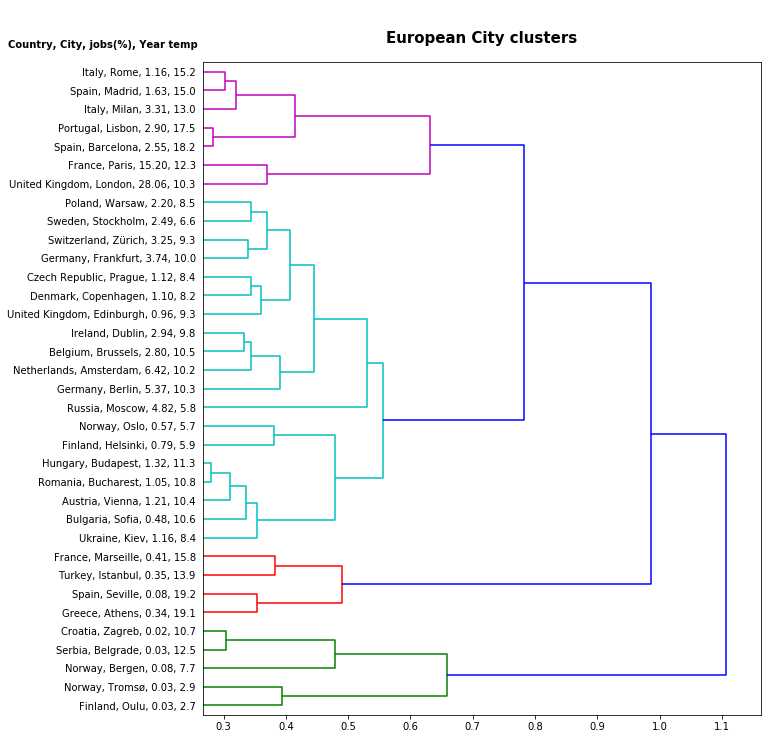

In [4]:
cdx = ctjf_wmink(ctjf_data2,tw=1,jw=1,fw=1)
#ctjf_dendro(cdx,'')
# labels = ttable.City.values
df = assembled_data
labels = ['{}, {}, {:.2f}, {}'.\
          format(df.Country[i],df.City[i],df.job_index[i]*100,df.Year[i]) for i in range(len(df.City.values))]
# hierarchical cluster
ccdx = hierarchy.complete(squareform(cdx)) # squareform is its own inverse, condenses and expands depending on the shape
plt.figure(figsize=(10,12))
R = hierarchy.dendrogram(ccdx,labels=labels,orientation='right',leaf_font_size=10)

mask = np.ones(cdx.shape, dtype=bool)
np.fill_diagonal(mask, 0)
plt.xlim(cdx[mask].min()*.95,cdx[mask].max()*1.05)
plt.title('European City clusters',fontdict={'fontsize': 15,'fontweight':'bold','verticalalignment':'baseline'},pad=20 )
plt.annotate('Country, City, jobs(%), Year temp',xy=(0.01,0.935),xycoords='figure fraction',\
             fontweight='bold')
plt.show()

<center><i><b>Figure 1</b>: European City Clusters. Cities were compared using weighted Minkowski distance, followed by hierarchical clustering with complete linkage. Legend: Country, City, % of Data Science jobs (from the total of these cities) and Average temperature for the Year in Celsius.</i></center>

**Figure 2** shows the City clusters on the map of Europe.

In [23]:
# Plotting the clusters on a map
df = assembled_data

# European map
lat = 55
lon = 12.102151
Fmap = folium.Map(
                #width=800,height=500,
                location=[float(lat), float(lon)], zoom_start=3 , control_scale = True)

# Plot cities and clusters  ---------------------------------------------------------------------------------

rainbow = '#e41a1c,#377eb8,#4daf4a,#ff7f00'.split(',')

# add markers to map
for lat, lng, cluster, city, country in zip(df['lat'], df['lon'], 
                                            c0_pres_table['Cluster'], df['City'], df['Country']):
     label = 'Cluster: {}, {}, {}'.format(cluster, city, country)
     label = folium.Popup(label, parse_html=True)
     folium.CircleMarker(  
        [lat, lng], radius=6, popup=label, color=rainbow[cluster-1],
        fill=True, fill_color=rainbow[cluster-1], fill_opacity=1, parse_html=False).add_to(Fmap)  
Fmap

<center><i><b>Figure 2</b>: Clusters of <b>Figure 1</b> displayed on the European Map</i></center>

The **Table 1** shows the cities most similar to Lisbon in temperature, Jobs and Foursquare venues, ordered by % of Jobs. London and Paris, being the best to find Data Science jobs, are also quite similar in the other criteria. Madrid is the closest geographically to Lisbon and is also similar in the 3 criteria analyzed. Finally, Barcelona, Milan and Rome also appear as similar cities in this comparison. 

In [5]:
# choosing the cluster that has Lisbon
c0_pres_table = pres_tablef.copy()
# define clusters - using default dendrogram cut method for the colors, from Matlab >> 0.7*max(Z[:,2])
# https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html
c0_pres_table['Cluster'] = hierarchy.fcluster(ccdx,0.7*max(ccdx[:,2]),'distance') 
chosen_cluster = c0_pres_table.loc[c0_pres_table.City=='Lisbon','Cluster'].values[0]
c0_pres_table.loc[c0_pres_table.Cluster==chosen_cluster].sort_values(by=['Cluster','Jobs (%)'],ascending=False)

,Country,City,Year Temp,Jobs (%),Most common venue,2nd most common,3rd most common,4th most common,5th most common,Cluster
17,United Kingdom,London,10.3,28.06,Hotel,Theater,Steakhouse,Indian Restaurant,Seafood Restaurant,4
24,France,Paris,12.3,15.20,French Restaurant,Plaza,Cocktail Bar,Sandwich Place,Wine Bar,4
20,Italy,Milan,13.0,3.31,Hotel,Boutique,Ice Cream Shop,Italian Restaurant,Dessert Shop,4
16,Portugal,Lisbon,17.5,2.90,Plaza,Wine Bar,Portuguese Restaurant,Scenic Lookout,Café,4
2,Spain,Barcelona,18.2,2.55,Tapas Restaurant,Hotel,Spanish Restaurant,Bookstore,Cocktail Bar,4
18,Spain,Madrid,15.0,1.63,Restaurant,Plaza,Hotel,Tapas Restaurant,Café,4
26,Italy,Rome,15.2,1.16,Plaza,Historic Site,Ice Cream Shop,Sandwich Place,Italian Restaurant,4


<center><i><b>Table 1</b>: The Lisbon Cluster. The Cluster containing Lisbon was isolated and displayed with the Yearly average temperature (Celsius), the 5 most common Foursquare Venue types per city and ordered by % of Data Science Jobs. The clusters are the same as in <b>Figure 1</b></i></center>

### For Junior Data Scientists 

Where should beginner Data Science practitioners from Lisbon go if hey want to move inside Europe? The 5 best job markets for Data Science were selected then compared to Lisbon based on temperature and venues. **Table 2** shows the results, ordered by % of similarity with Lisbon (Match). Although London has the highest number of opportunities, Paris and Amsterdam are more similar to Lisbon based on the other criteria. 

In [24]:
# Top 5 markets
sel_t5j = list(pres_tablef.sort_values(by='Jobs (%)',ascending=False).head(5).City.values)
# I'm selecting Lisbon as the comparison city
base_city = ['Lisbon']
sel_c1 = base_city + sel_t5j
sel_c1_ind = [pd.Index(pres_tablef.City).get_loc(x) for x in sel_c1]
c1_pres_table = pres_tablef.iloc[sel_c1_ind,:].copy()
# now I can get the similarity matrix using zero weight for jobs to compare temperature and venues 
dx_junior = ctjf_wmink(ctjf_data2,tw=1,jw=0,fw=1)
dx_junior_df = pd.DataFrame(dx_junior,index=ctjf_data2.City.values,columns=ctjf_data2.City.values)
c1_pres_table['Match'] = dx_junior_df.loc[sel_c1,base_city].apply(lambda x: 100*(1-x)).round(2).values
c1_pres_table = c1_pres_table.sort_values(by='Match',ascending=False)
c1_pres_table

,Country,City,Year Temp,Jobs (%),Most common venue,2nd most common,3rd most common,4th most common,5th most common,Match
16,Portugal,Lisbon,17.5,2.90,Plaza,Wine Bar,Portuguese Restaurant,Scenic Lookout,Café,100.00
24,France,Paris,12.3,15.20,French Restaurant,Plaza,Cocktail Bar,Sandwich Place,Wine Bar,58.45
0,Netherlands,Amsterdam,10.2,6.42,Hotel,French Restaurant,Sandwich Place,Bookstore,Restaurant,51.00
17,United Kingdom,London,10.3,28.06,Hotel,Theater,Steakhouse,Indian Restaurant,Seafood Restaurant,50.58
5,Germany,Berlin,10.3,5.37,Coffee Shop,Bookstore,Park,History Museum,Monument / Landmark,49.16
21,Russia,Moscow,5.8,4.82,Plaza,Art Gallery,Road,Bookstore,Hotel,25.35


<center><i><b>Table 2</b>: The Junior Data Scientist case. The 5 best job markets were selected and compared to Lisbon based on temperature and Foursquare venues, using weighted Minkowski distance (same weight for temperature and venues). The match score is 1 minus the Minkowski distance times 100.</i></center>

### For Mid-level Data Scientists

Where should the mid-level Data Science practitioners form Lisbon go? **Table 3** shows the results where cities were compared using the same weights for temperature, jobs and Foursquare venues. For people comfortable finding jobs in the Lisbon market it seems that Barcelona, Rome and Madrid are good options, with similar numbers of jobs, temperature and venues.

In [32]:
# dissimilarity matrix
dx_mid = ctjf_wmink(ctjf_data2,tw=1,jw=1,fw=1)
# convert to df
dx_mid_df = pd.DataFrame(dx_mid,index=ctjf_data2.City.values,columns=ctjf_data2.City.values)
# select the best 5 matches to base_city
c2_matches = dx_mid_df[base_city].sort_values(by=base_city).head(6)
sel_c2 = list(c2_matches.index.values)
# index in pres_tablef
sel_c2_ind = [pd.Index(pres_tablef.City).get_loc(x) for x in sel_c2]
c2_pres_table = pres_tablef.iloc[sel_c2_ind,:].copy()
c2_pres_table['Match'] = c2_matches.apply(lambda x: 100*(1-x)).round(2).values
# result
c2_pres_table

,Country,City,Year Temp,Jobs (%),Most common venue,2nd most common,3rd most common,4th most common,5th most common,Match
16,Portugal,Lisbon,17.5,2.90,Plaza,Wine Bar,Portuguese Restaurant,Scenic Lookout,Café,100.00
2,Spain,Barcelona,18.2,2.55,Tapas Restaurant,Hotel,Spanish Restaurant,Bookstore,Cocktail Bar,71.76
26,Italy,Rome,15.2,1.16,Plaza,Historic Site,Ice Cream Shop,Sandwich Place,Italian Restaurant,67.29
18,Spain,Madrid,15.0,1.63,Restaurant,Plaza,Hotel,Tapas Restaurant,Café,66.36
20,Italy,Milan,13.0,3.31,Hotel,Boutique,Ice Cream Shop,Italian Restaurant,Dessert Shop,60.49
19,France,Marseille,15.8,0.41,Plaza,Hotel,Bar,French Restaurant,Provençal Restaurant,59.67


<center><i><b>Table 3</b>: The mid-level Data Scientist case. Cities were compared to Lisbon based on temperature, jobs and Foursquare venues, using weighted Minkowski distance (same weight for the 3 data types). The match score is 1 minus the Minkowski distance times 100.</i></center>

### For Senior Data Scientists

Where should Senior Data Scientists from Lisbon go? In **Table 4** the cities were compared to Lisbon based only on temperature and Foursquare venues. Barcelona, Seville and Marseille appear as the most prominent options. 

In [33]:
# dissimilarity matrix
dx_mid = ctjf_wmink(ctjf_data2,tw=1,jw=0,fw=1)
# convert to df
dx_mid_df = pd.DataFrame(dx_mid,index=ctjf_data2.City.values,columns=ctjf_data2.City.values)
# select the best 5 matches to base_city
c3_matches = dx_mid_df[base_city].sort_values(by=base_city).head(6)
sel_c3 = list(c3_matches.index.values)
# index in pres_tablef
sel_c3_ind = [pd.Index(pres_tablef.City).get_loc(x) for x in sel_c3]
c3_pres_table = pres_tablef.iloc[sel_c3_ind,:].copy()
c3_pres_table['Match'] = c3_matches.apply(lambda x: 100*(1-x)).round(2).values
# result
c3_pres_table

,Country,City,Year Temp,Jobs (%),Most common venue,2nd most common,3rd most common,4th most common,5th most common,Match
16,Portugal,Lisbon,17.5,2.90,Plaza,Wine Bar,Portuguese Restaurant,Scenic Lookout,Café,100.00
2,Spain,Barcelona,18.2,2.55,Tapas Restaurant,Hotel,Spanish Restaurant,Bookstore,Cocktail Bar,71.82
27,Spain,Seville,19.2,0.08,Tapas Restaurant,Spanish Restaurant,Plaza,Hotel,Ice Cream Shop,71.69
19,France,Marseille,15.8,0.41,Plaza,Hotel,Bar,French Restaurant,Provençal Restaurant,69.99
26,Italy,Rome,15.2,1.16,Plaza,Historic Site,Ice Cream Shop,Sandwich Place,Italian Restaurant,69.80
18,Spain,Madrid,15.0,1.63,Restaurant,Plaza,Hotel,Tapas Restaurant,Café,67.30


<center><i><b>Table 4</b>: The senior Data Scientist case. Cities were compared to Lisbon based on temperature and Foursquare venues, using weighted Minkowski distance (same weight for temperature and venues, zero weight for jobs). The match score is 1 minus the Minkowski distance times 100.</i></center>

### For Companies

Where should Companies from Lisbon look for Data Science talent? In **Table 5** the 5 cities with the least amount of Data Science job postings were selected, then compared to Lisbon based on temperature and Foursquare venues. Belgrade, Zagreb and Bergen appear as the top 3 matches. 

In [34]:
# Bottom 5 markets
sel_b5j = list(pres_tablef.sort_values(by='Jobs (%)',ascending=True).head(5).City.values)
# I'm selecting Lisbon as the comparison city
base_city = ['Lisbon']
sel_c4 = base_city + sel_b5j
sel_c4_ind = [pd.Index(pres_tablef.City).get_loc(x) for x in sel_c4]
c4_pres_table = pres_tablef.iloc[sel_c4_ind,:].copy()
# now I can get the similarity matrix using zero weight for jobs to compare temperature and venues 
dx_junior = ctjf_wmink(ctjf_data2,tw=1,jw=0,fw=1)
dx_junior_df = pd.DataFrame(dx_junior,index=ctjf_data2.City.values,columns=ctjf_data2.City.values)
c4_pres_table['Match'] = dx_junior_df.loc[sel_c4,base_city].apply(lambda x: 100*(1-x)).round(2).values
c4_pres_table = c4_pres_table.sort_values(by='Match',ascending=False)
c4_pres_table

,Country,City,Year Temp,Jobs (%),Most common venue,2nd most common,3rd most common,4th most common,5th most common,Match
16,Portugal,Lisbon,17.5,2.90,Plaza,Wine Bar,Portuguese Restaurant,Scenic Lookout,Café,100.00
3,Serbia,Belgrade,12.5,0.03,Restaurant,Coffee Shop,Bar,Café,Cocktail Bar,57.16
33,Croatia,Zagreb,10.7,0.02,Café,Plaza,Bar,Dessert Shop,Restaurant,53.42
4,Norway,Bergen,7.7,0.08,Bar,Café,Hotel,Coffee Shop,Scandinavian Restaurant,40.05
30,Norway,Tromsø,2.9,0.03,Hotel,Bar,Café,Grocery Store,Coffee Shop,15.35
23,Finland,Oulu,2.7,0.03,Grocery Store,Pizza Place,Café,Fast Food Restaurant,Hotel,11.73


<center><i><b>Table 5</b>: The case of companies looking for Data Science talent. The 5 worst job markets were selected and compared to Lisbon based on temperature and Foursquare venues, using weighted Minkowski distance (same weight for temperature and venues). The match score is 1 minus the Minkowski distance times 100.</i></center>

## Discussion

Cities have so many characteristics that comparing them based on 3 criteria can only be described as simplistic. However, this approach seems useful enough to capture the essence of the problem and provide solutions that seems both viable and interesting.

For junior Data Scientists, the assumptions were that 1) they give the highest importance to the number of job opportunities, 2) they want to move to a place similar to where they currently live. Based on these assumptions, the comparison of temperature and Foursquare venues gives Paris, Amsterdam and London as best options.

For mid-level practitioners, the assumption was that they would give the same level of importance to the 3 criteria, assuming they could easily find jobs on similar job markets. Bases on this, Barcelona, Rome and Madrid appeared as the best options.

For senior Data Scientists, that could easily find jobs anywhere these days (even remotely), the assumption was that, if they want to move to a similar city, only the temperature and Foursquare data would be considered. However the best option in this comparison, Barcelona, has also a similar number of job opportunities as Lisbon, and would seem like a good choice. Seville and Marseille come in second and third in the comparison, respectively.

Other criteria can be included in the future to further improve these comparisons, such as rainfall, cost of living (rent, food prices, transportation), housing availability, criminality, and types of Data Science jobs (entry, mid or senior level).

## Conclusion

**Where should Data Scientists from Lisbon move to?**   
- **Junior**: Paris, Amsterdam or London.   
- **Mid-level**: Barcelona, Rome or Madrid.   
- **Senior**: Barcelona, Seville or Marseille.   

**Where should companies from Lisbon look to hire Data Science talent from?** Belgrade, Zagreb or Bergen.